In [50]:
!gsutil -m cp gs://firstbucketpractice/model/cats_vs_dogs.h5 .

Copying gs://firstbucketpractice/model/cats_vs_dogs.h5...
- [1/1 files][  8.9 MiB/  8.9 MiB] 100% Done                                    
Operation completed over 1 objects/8.9 MiB.                                      


In [51]:
import tensorflow as tf

model = tf.keras.models.load_model('cats_vs_dogs.h5')  # to load the model
model.summary()

# uses cnn model ,based on mobilenet architecture and used transfer learning for training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
# testing the model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [53]:
classes = ['Cat','Dog']
def display_prediction(image_path):
    plt.imshow(plt.imread(image_path))
    
    x= tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128)) # input size is 128,128 image
    
    x = tf.keras.preprocessing.image.img_to_array(x)
    
    x= tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    x= np.expand_dims(x,axis=0)
    
    pred = model.predict(x)[0]
    
    plt.title('Pred:{}'.format(classes[int(pred > 0.5)]))  # if prediciton > 0.5 its dog
    plt.show()
    
    
    print(pred)   # raw values
    
    

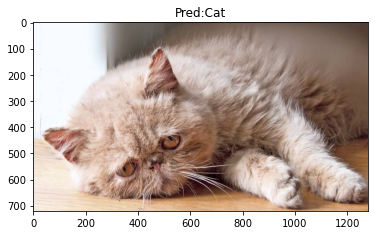

[0.00418768]


In [54]:
images = ['images/cat1.jpg','images/cat2.jpg','images/dog1.jpg','images/dog2.jpg']

display_prediction(images[0])

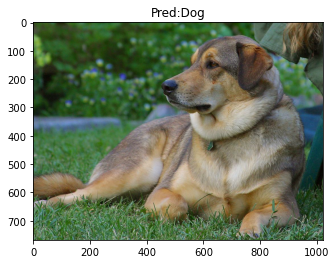

[0.9928952]


In [55]:
display_prediction(images[-1])

In [56]:
%%writefile prediction.py  
# code in the cell written as prediciton.py file
# Cusotm prediction file

import tensorflow as tf
import numpy as np
import os
import base64

MODEL_NAME ='cats_vs_dogs.h5'
CLASS_NAMES=['Cat','Dog']
class CatsVsDogsPredicition:
    def __init__(self,model):
        self.model = model
    
    def _preprocess(self,instances,size=128):
        # decode the data, we get encoded data from instances
        num_examples = len(instances)
        x_batch =np.zeros((num_examples,size,size,3))
        for i in range(num_examples):
            x=np.array(bytearray(base64.b64decode(instances[i])))  # decodes data from string to byte
            x =np.reshape(x, (size,size,3))
            x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
            x_batch[i]=x
        return x_batch   
    
    def _postprocess(self,preds):
        results = []
        for i, pred in enumerate(preds):
            p = np.squeeze(pred)
            results.append({'index':i,'class_name':CLASS_NAMES[int(p > 0.5)],
                           'raw_value': '{:.4f}'.format(p)
                           })
        return results
    
    def predict(self,instances,**kwargs):
        if 'size' in kwargs:
            size =int(kwargs.get('size'))
        else:
            size=128
        # Preprocess
        x_batch = self._preprocess(instances,size)
        # Predict
        preds = self._model.predict(x_batch)
        # Post Process
        results = self._postprocess(preds)
        return results
    @classmethod
    def from_path(cls,model_dir):
        model = tf.keras.models.load_model(os.path.join(model_dir,MODEL_NAME))
        return cls(model)  # returns instance of class

Overwriting prediction.py


In [57]:
%%writefile setup.py

from setuptools import setup

setup(
    name='cats_vs_dogs',
    version='0.0.1',
    include_package_data=False,
    scripts = ['prediction.py']
)

Overwriting setup.py


In [58]:
!python3 setup.py sdist --formats=gztar

running sdist
running egg_info
writing cats_vs_dogs.egg-info/PKG-INFO
writing dependency_links to cats_vs_dogs.egg-info/dependency_links.txt
writing top-level names to cats_vs_dogs.egg-info/top_level.txt
reading manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'
writing manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'

running check


creating cats_vs_dogs-0.0.1
creating cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying files to cats_vs_dogs-0.0.1...
copying prediciton.py -> cats_vs_dogs-0.0.1
copying prediction.py -> cats_vs_dogs-0.0.1
copying setup.py -> cats_vs_dogs-0.0.1
copying cats_vs_dogs.egg-info/PKG-INFO -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/SOURCES.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/dependency_links.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/top_level.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
Writing cats_vs_dogs-0.0.1/setup.cfg
Creating tar archive
removing 

In [59]:
!gsutil cp dist/cats_vs_dogs-0.0.1.tar.gz gs://firstbucketpractice/dist/

Copying file://dist/cats_vs_dogs-0.0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  1.5 KiB/  1.5 KiB]                                                
Operation completed over 1 objects/1.5 KiB.                                      


In [60]:
# Deploying the model in AI platform 
# create a model
# choose model file and 
#distribution tar file as we are using custom prediction
# give prediction name predicition.CatsVsDogsPrediciton

In [61]:
from googleapiclient import discovery
from PIL import Image
import os
import base64

In [62]:
service = discovery.build('ml','v1',cache_discovery=False)

In [63]:
def get_pred_from_model(body,project_name,model_name):
    return service.projects().predict(
        name='projects/{}/models/{}'.format(project_name,model_name),
        body = body
    ).execute()

In [64]:
project_name = 'swift-icon-250706'
model_name = 'cats_vs_dogs'

In [65]:
images

['images/cat1.jpg', 'images/cat2.jpg', 'images/dog1.jpg', 'images/dog2.jpg']

In [66]:
instances = []
size = 128

for image in images:
    img = Image.open(image)
    img = img.resize((size,size),Image.ANTIALIAS)
    
    instances.append(
        base64.b64encode(img.tobytes()).decode()
    )
    img.close()

In [67]:
body = {
    'instances' : instances,
    'size' : size
}

In [68]:
response = get_pred_from_model(body,project_name,model_name)

In [69]:
response

{'error': 'Prediction failed: unknown error.'}

In [ ]:
!gs 